# Anexos

Este apartado contiene en detalle el análisis de datos, preprocesamiento, análisis de exploratorio de las variables de interés junto con su explicación. La función de este anexo es de apoyo al texto principal.

## Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from haversine import haversine, Unit

plt.style.use('seaborn')
%matplotlib inline

## A1 - Analisis de datos

El set de datos inicial esta compuesto por cuatros archivos .csv. Los atributos junto con su descripción se presentan a continuación:

__Orden_compra__  
- id_orden : Identificador del pedido de compra.
- Latitud : Dirección de entrega.
- Longitud : Dirección de entrega.
- Dia : Día de la semana en que se prometió la orden
    0: domingo
    1: lunes
    2: martes
    3: miercoles
    4: jueves
    5: viernes
    6: sabado
- Promesa : Hora de entrega prometida al cliente.
- Entrega : Hora en que se entregó el pedido al cliente.
- id_entrega : Si el pedido fue solicitado en “Menos de 90 minutos” o en una ventana horario en el futuro.
- id_recolector : Identificador de la persona que recolectó el pedido.
- id_trasporte : Identificador de la persona que hizo transporte del pedido.
- id_tienda : Identificador del local en que se realizó la compra.
- Tiempo : Tiempo total que demoró completar la orden (desde la compra hasta la entrega).

__Orden_productos__  
- id_orden : Identificador del pedido de compra
- id_productos : Identificador del producto.
- cant_producto : Cantidad solicitada del producto por el cliente.
- cant_encontrada : Cantidad solicitada del producto por el cliente.
- Unidad : Formato en que se vendió el producto (Unidades o KG).

__Recolector__  
- id_recolector : Identificador recolector.
- Clasificación_recolector : Clasificación de experiencia recolector.
- P_aciertos : Porcentaje histórico de productos que el recolector encontró.
- velocidad : Velocidad histórica de recogida de productos.
- P_aceptacion : Porcentaje histórico de pedidos aceptado por el recolector.
- Score_Recolector : Evaluación del recolector.

__Tienda__  
- id_tienda : Identificador de la tienda.
- tienda : Identificador de la tienda a la cual pertenece de la tienda.
- latitud_tienda : Latitud de la ubicación de la tienda.
- Longitud_tienda : Longitud de la ubicación de la tienda.

### A1.1 - Compra

In [2]:
compra = pd.read_csv('data/1_Orden_compra.csv', sep=';')
compra.head()

,order_id,lat,lng,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800.861
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599.732
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458.001
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778.761
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321.208


In [3]:
#Variable categorica
compra['on_demand'].value_counts()

False    4225
True     3070
Name: on_demand, dtype: int64

In [4]:
#Se recodifica el atributo Booleano
compra['on_demand'] = np.where(compra['on_demand'] == False, 1, 0)

In [5]:
compra['on_demand'].value_counts()

1    4225
0    3070
Name: on_demand, dtype: int64

In [6]:
#Se actualizan los nombres de los atributos en el dataset
compra.rename(columns={'order_id':'id_orden', 'lat':'latitud', 'lng':'longitud', 'dow':'dia', 'promised_time':'promesa',
                       'actual_time':'entrega', 'on_demand':'id_entrega', 'picker_id':'id_recolector', 
                       'driver_id':'id_trasporte', 'store_branch_id':'id_tienda', 'total_minutes':'tiempo'}, inplace=True)

In [7]:
print("La cantidad de registros es de:", compra.shape[0])
print("La cantidad de atributos es de:", compra.shape[1])

La cantidad de registros es de: 7295
La cantidad de atributos es de: 11


In [8]:
#Se hace una tabla para observar los missing values
total = compra.isnull().sum().sort_values(ascending=False)
percent = round((compra.isnull().sum() / compra.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
tiempo,752,10.31
id_tienda,0,0.00
id_trasporte,0,0.00
id_recolector,0,0.00
id_entrega,0,0.00
entrega,0,0.00
promesa,0,0.00
dia,0,0.00
longitud,0,0.00
latitud,0,0.00


Se puede apreciar que en este dataset sólo el atributo `tiempo` contiene datos perdidos, con un monto de __752__ registros, los cuales representan el __10.31%__ de la data, por tal motivo se hará una eliminación de dichos datos, el motivo es que este atributo es nuestra variable objetivo y no queremos que se vea afectada por ningún motivo.

In [9]:
compra.dropna(inplace=True)

In [10]:
print("La cantidad de registros es de:", compra.shape[0])
print("La cantidad de atributos es de:", compra.shape[1])

La cantidad de registros es de: 6543
La cantidad de atributos es de: 11


### A1.2 - Productos

In [11]:
productos = pd.read_csv('data/2_Orden_productos.csv', sep=';')
productos.head()

,order_id,product_id,quantity,quantity_found,buy_unit
0,bdfc44fb525986b7bab8c589fc47e853,ab9757d9892b0e83ab3a1c1af0c84c52,0.75,0.155,KG
1,bdfc44fb525986b7bab8c589fc47e853,f1f042251bf634d44f338fbaf13b16e4,0.3,0.400,KG
2,bdfc44fb525986b7bab8c589fc47e853,0630d47440965509b0b3f80fd1b3578f,1,1.000,UN
3,bdfc44fb525986b7bab8c589fc47e853,9dd69b1f300666d5573e3a9934f2e03e,2,2.000,UN
4,bdfc44fb525986b7bab8c589fc47e853,3dfcdbe308bde67370649dd875f2507b,1,1.000,UN


In [12]:
#Se actualiza el nombre del atributo que identifica la orden de compra
productos.rename(columns={'order_id':'id_orden'}, inplace=True)

In [13]:
print("La cantidad de registros es de:", productos.shape[0])
print("La cantidad de atributos es de:", productos.shape[1])

La cantidad de registros es de: 120876
La cantidad de atributos es de: 5


No se encontraron datos perdidos en este dataset.

In [14]:
productos.isnull().any()

id_orden          False
product_id        False
quantity          False
quantity_found    False
buy_unit          False
dtype: bool

Se procederá a separar aquellos productos que se pesan y se contabilizan como 1, los que son por unidad mantendremos la cantidad. 
El objetivo de esta segmentación es posteriormente tener una columna de productos que son pesado y otras que son por unidad, ya que para este caso sólo nos importa la cantidad total de productos (pesados y por unidad) por orden, si bien tenemos un código de producto por el momento no podremos determinar el tipo de producto, si tendríamos esa información disponible podríamos determinar que productos que son pesados pueden influenciar más o menos en el tiempo de entrega, así que, nos concentraremos en la cantidad de productos por orden.

In [15]:
#Creamos una columna de tipo bandera, para determinar que las cantidades que están en el atributo quantity,
#correspondan con su respectiva unidad
productos['cantidad_ajustada'] = np.where(productos['buy_unit'] == 'KG' , 1, productos['quantity'])
productos['cantidad_ajustada'] = pd.to_numeric(productos['cantidad_ajustada'])

Para este caso cuando se evaluó la columna de "tipo bandera"--> `cantidad_ajustada`, se pudo apreciar que teníamos 2 casos anómalos ya que acá todos los valores tenían que ser entero y descubrimos que existen 2 casos donde en la columna `quantity` hay valores decimales y en la columna `buy_unit` su valor es __UN__ representando esto como Unidad, cuando en realidad es de tipo __KG__, se prodecerá a actualizar estos registros y volver a actualizar la columna `cantidad_ajustada`.

In [16]:
no_KG = productos.loc[(productos['cantidad_ajustada'] == 0.225) | (productos['cantidad_ajustada'] == 0.090)]
no_KG.head()

,id_orden,product_id,quantity,quantity_found,buy_unit,cantidad_ajustada
29253,7a1be969ec97b66b710f7dc5b80f8a6f,068566a7b65d4093075f13ae383aa3d4,0.09,0.090,UN,0.090
96244,a5fc3ba3db31ac6a1ea5ddb87dcbc596,e0922ceeaeb05c556c27138d10305932,0.225,0.225,UN,0.225


Existen par de productos que en la __unidad de compra__ marcan como __"UN"__ cuando en realidad son de tipo __"KG"__.

In [17]:
#Se reemplazan esos valores por los verdaderos
productos.loc[29253, 'buy_unit'] = 'KG'
productos.loc[96244, 'buy_unit'] = 'KG'

In [18]:
#Se actualizan los datos
productos['cantidad_ajustada'] = np.where(productos['buy_unit'] == 'KG' , 1, productos['quantity'])
productos['cantidad_ajustada'] = pd.to_numeric(productos['cantidad_ajustada'])

No se encontraron Outliers.

Separamos en tipo de productos: Aquellos que se pesan y aquellos que no, además, crearemos una columna extra que será la cantidad total, conformada por la suma entre los productos sin pesar con los que se pesan.

In [19]:
tipo = pd.get_dummies(productos['buy_unit'])

In [20]:
productos['sin_pesar'] = tipo['UN']
productos['pesados'] = tipo ['KG']
productos['cantidad_total'] = productos['sin_pesar'] + productos['pesados']
productos.drop(columns=['quantity', 'quantity_found', 'buy_unit', 'product_id', 'cantidad_ajustada'], inplace=True)

In [21]:
productos_agrupados = productos.groupby(by='id_orden').sum().reset_index()

In [22]:
productos_agrupados.head()

,id_orden,sin_pesar,pesados,cantidad_total
0,001ef94c50c71cb0e674b6293e9b6068,30,5,35
1,001f7583bb106a338d09a12a89e54cbd,5,0,5
2,002b6dcb32fef90ebb1cb691afe6a413,9,0,9
3,002ebc46f3e40c49044aceb8311df432,3,1,4
4,002f97bd7dad0d275d8511436c18b572,7,4,11


Finalmente, se hizo una agrupación del dataframe por número de orden, así consideramos solamente los productos que son pesado y los que no son pesados y la suma total de ellos.

### A1.3 - Recolector

In [23]:
recolector = pd.read_csv('data/3_Recolector.csv', sep=";")
recolector.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,087ab65ceca40dbef697f585dc159d5d,ADVANCED,0.8610,1.64,1.00,4.48
1,645973c41314d763b58dc2bceeeeffc9,INTERMEDIATE,0.8337,2.83,0.96,4.79
2,82810715fdda44962e7e422015ea1f32,ADVANCED,0.8681,1.27,0.88,4.84
3,416aa7dbd5a2f58d7bca96657e8faa1e,INTERMEDIATE,0.8784,2.11,1.00,NaN
4,27a3e845a4c3eb7ded4748f84140a843,ADVANCED,0.8466,1.50,1.00,4.84


In [24]:
print("La cantidad de registros es de:", recolector.shape[0])
print("La cantidad de atributos es de:", recolector.shape[1])

La cantidad de registros es de: 600
La cantidad de atributos es de: 6


In [25]:
#Se renombran las columnas del dataset
recolector.rename(columns={'shopper_id':'id_recolector', 'seniority':'clasificacion_recolector', 
                           'found_rate':'p_aciertos', 'picking_speed':'velocidad', 
                           'accepted_rate':'p_aceptacion', 'rating':'score_recolector'}, inplace=True)

Tenemos algunos datos perdidos en el dataset por lo que determinaremos la cantidad que representa cada atributo para posteriormente aislar estos casos y analizarlos de una mejor manera.

In [26]:
recolector.isnull().any()

id_recolector               False
clasificacion_recolector    False
p_aciertos                   True
velocidad                   False
p_aceptacion                 True
score_recolector             True
dtype: bool

In [27]:
total = recolector.isnull().sum().sort_values(ascending=False)
percent = round((recolector.isnull().sum() / recolector.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
p_aciertos,36,6.00
score_recolector,34,5.67
p_aceptacion,6,1.00
velocidad,0,0.00
clasificacion_recolector,0,0.00
id_recolector,0,0.00


Podemos apreciar que existen __3 atributos__ los cuales tienen algunos datos perdidos, donde se representa en porcentaje la cifra de ellos en c/u.

Para este caso tenemos pocos atributos en nuestro dataset, por lo que emplearemos la técnica `get_dummies` para separar y convertir en nuevos atributos la columna `clasificacion_recolector`, la cual representa la clasificación del recolector y para este caso tenemos sólo __4 tipos__.

In [28]:
#Se contabilizan las categorías del atributo 'clasificacion_recolector'
recolector['clasificacion_recolector'].value_counts()

ADVANCED        268
INTERMEDIATE    204
REVIEW           99
BEGINNER         29
Name: clasificacion_recolector, dtype: int64

In [29]:
recolector = pd.get_dummies(recolector, columns=['clasificacion_recolector'], prefix='seniority', prefix_sep='_')

In [30]:
recolector.head()

,id_recolector,p_aciertos,velocidad,p_aceptacion,score_recolector,seniority_ADVANCED,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW
0,087ab65ceca40dbef697f585dc159d5d,0.8610,1.64,1.00,4.48,1,0,0,0
1,645973c41314d763b58dc2bceeeeffc9,0.8337,2.83,0.96,4.79,0,0,1,0
2,82810715fdda44962e7e422015ea1f32,0.8681,1.27,0.88,4.84,1,0,0,0
3,416aa7dbd5a2f58d7bca96657e8faa1e,0.8784,2.11,1.00,NaN,0,0,1,0
4,27a3e845a4c3eb7ded4748f84140a843,0.8466,1.50,1.00,4.84,1,0,0,0


### A1.4 - Tiendas

In [31]:
tienda = pd.read_csv('data/4_tienda.csv', sep=';')
tienda.head()

,store_branch_id,store,lat,lng
0,cf0895f1e3beb8164f0a86e6f940ae56,c0b93cf93cf854981b8d6bd849eec4b0,18.160.308.413.602.800,-10.026.067.265.111.100
1,3ddd4c29cab4178d89d549c6ba65c236,044d56734d20e04984d846dade6d39f3,1.827.282.968.914.450,-10.031.881.435.593.900
2,e9763f24fd46d0b9e52d423207a87c3c,452ae015bf846e1d2932b7ea15720d64,18.273.494.015.704.800,-10.031.958.539.978.200
3,49b7d60d6095a9f1129ce798102b62f4,6447951cd071f6f045fd4e6194920926,1.824.774.341.566.610,-10.040.355.771.938.600
4,8f21cfda17b340aeee062220d0bee8e5,452ae015bf846e1d2932b7ea15720d64,18.203.111.495.565.700,-10.029.771.361.550.100


Podemos apreciar que no tenemos datos perdidos en el dataset.

In [32]:
tienda.isnull().any()

store_branch_id    False
store              False
lat                False
lng                False
dtype: bool

In [33]:
print("La cantidad de registros es de:", tienda.shape[0])
print("La cantidad de atributos es de:", tienda.shape[1])

La cantidad de registros es de: 113
La cantidad de atributos es de: 4


In [34]:
#Se renombran las columnas del dataset
tienda.rename(columns={'store_branch_id':'id_tienda', 'store':'tienda', 'lat':'latitud_tienda',
                       'lng':'longitud_tienda'}, inplace=True)

### A1.5 - Consolidación

In [80]:
#Consolidación de los df compra y prodructos
df = pd.merge(compra, productos_agrupados, how='left', on='id_orden')

In [81]:
#Consolidación del df con recolector
df = pd.merge(df, recolector, how='left', on='id_recolector')

In [82]:
#consolidación de todos los dataset
df = pd.merge(df, tienda, how='left', on='id_tienda')

In [83]:
print("La cantidad de registros final es de:", df.shape[0])
print("La cantidad de atributos final es de:", df.shape[1])

La cantidad de registros final es de: 6543
La cantidad de atributos final es de: 25


In [84]:
df.to_csv('data/consolidado.csv', header=True, index=False)

Finalmente, tenemos nuestro dataset consolidado, vamos a proceder a evaluarlo para determinar si hay casos con datos perdidos y/o anómalos.

In [85]:
df.head()

,id_orden,latitud,longitud,dia,promesa,entrega,id_entrega,id_recolector,id_trasporte,id_tienda,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,seniority_ADVANCED,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,tienda,latitud_tienda,longitud_tienda
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,1,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800.861,17.0,10.0,27.0,0.8564,1.56,1.00,4.68,1,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,1,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599.732,88.0,15.0,103.0,0.8516,1.14,1.00,4.76,1,0,0,0,387d4a5b65cf4bf00ad805c4b00eed01,18.163.960.871.027.900,-10.032.899.405.911.000
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,1,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458.001,6.0,0.0,6.0,0.8337,2.03,1.00,4.96,0,0,1,0,0fae7b61265bc7ca4ce4d81440b62501,1.824.565.541.228.880,-1.003.324.934.760.470
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,1,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778.761,12.0,5.0,17.0,0.8571,2.06,0.92,4.92,0,0,1,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,1,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321.208,28.0,16.0,44.0,0.8625,1.89,1.00,4.92,1,0,0,0,452ae015bf846e1d2932b7ea15720d64,1.823.159.108.764.060,-10.031.450.001.698.800


Existen datos perdidos en el dataset consolidado,vamos a calcular la cantidad en cada atributo, se mostrarán dichos datos en una tabla.

In [86]:
df.isnull().any()

id_orden                  False
latitud                   False
longitud                  False
dia                       False
promesa                   False
entrega                   False
id_entrega                False
id_recolector             False
id_trasporte              False
id_tienda                 False
tiempo                    False
sin_pesar                  True
pesados                    True
cantidad_total             True
p_aciertos                 True
velocidad                 False
p_aceptacion               True
score_recolector           True
seniority_ADVANCED        False
seniority_BEGINNER        False
seniority_INTERMEDIATE    False
seniority_REVIEW          False
tienda                    False
latitud_tienda            False
longitud_tienda           False
dtype: bool

Acá podremos observar la cantidad de datos perdidos por atributo y cuanto significa cada uno de ellos en porcentaje; tenemos 6 atributos con datos perdidos, para este caso vamos a imputar 3 de ellos `p_aciertos, score_recolector y p_aceptacion`, la imputación se hará rellenando los valores perdidos con la media de la columna, para efectos en el modelamiento no tendrá ninguno ya que los valores de los registros están concentrados en esa área y no afectaría de manera relevante, además, salvaríamos esos datos para un mejor resultado. A continuación, se detalla el proceso de cada variable:

In [87]:
pd.set_option('display.max_columns', 100)

In [88]:
total = df.isnull().sum().sort_values(ascending=False)
percent = round((df.isnull().sum() / df.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
p_aciertos,75,1.15
score_recolector,70,1.07
pesados,15,0.23
cantidad_total,15,0.23
sin_pesar,15,0.23
p_aceptacion,5,0.08
id_tienda,0,0.00
latitud,0,0.00
longitud,0,0.00
dia,0,0.00


In [89]:
#Creamos una copia del dataframe para hacer una eliminación de valores perdidos para posteriormente
#calcular la media de los atributos que vamos a imputar
df2 = df.copy()
df2.dropna(inplace=True)

#### Imputación: Porcentaje histórico de productos que el recolector encontró

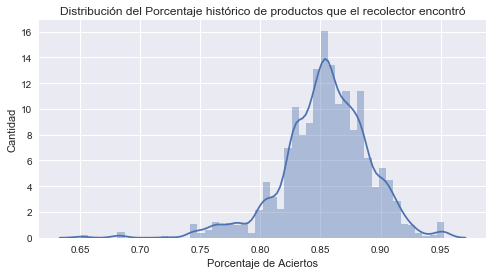

In [90]:
plt.figure(figsize=(8, 4))
sns.distplot(df2.p_aciertos)
plt.xlabel("Porcentaje de Aciertos")
plt.ylabel("Cantidad")
plt.title("Distribución del Porcentaje histórico de productos que el recolector encontró");

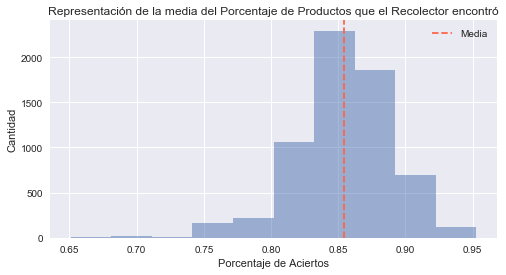

In [91]:
plt.figure(figsize=(8, 4))
plt.hist(df2['p_aciertos'], alpha=0.5)
plt.axvline(df2.p_aciertos.mean(), color='tomato', ls='--', label='Media')
plt.xlabel("Porcentaje de Aciertos")
plt.ylabel("Cantidad")
plt.title("Representación de la media del Porcentaje de Productos que el Recolector encontró")
plt.legend();

In [92]:
#Se reemplazan los datos perdidos del atributo por la media del mismo
df['p_aciertos'].replace(np.nan, df2['p_aciertos'].mean(), inplace=True)

#### Imputación: Porcentaje histórico de pedidos aceptado por el recolector

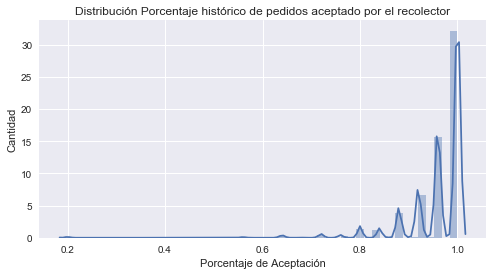

In [93]:
plt.figure(figsize=(8, 4))
sns.distplot(df2['p_aceptacion'])
plt.xlabel("Porcentaje de Aceptación")
plt.ylabel("Cantidad")
plt.title("Distribución Porcentaje histórico de pedidos aceptado por el recolector");

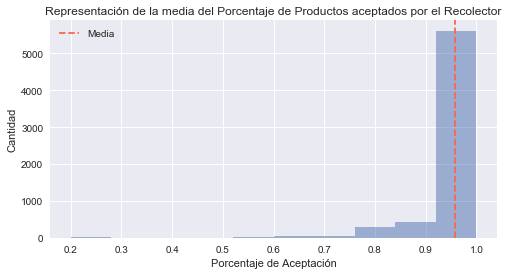

In [94]:
plt.figure(figsize=(8, 4))
plt.hist(df2['p_aceptacion'], alpha=0.5)
plt.axvline(df2['p_aceptacion'].mean(), color='tomato', ls='--', label="Media")
plt.xlabel("Porcentaje de Aceptación")
plt.ylabel("Cantidad")
plt.title("Representación de la media del Porcentaje de Productos aceptados por el Recolector")
plt.legend();

In [95]:
#Se reemplazan los datos perdidos del atributo por la media del mismo
df['p_aceptacion'].replace(np.nan, df2['p_aceptacion'].mean(), inplace=True)

#### Imputación: Score del Recolector

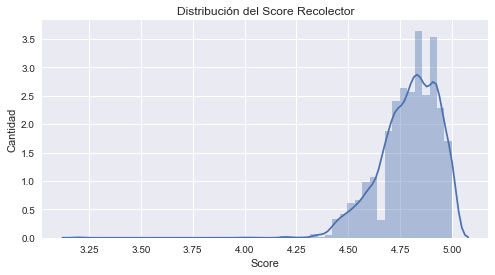

In [96]:
plt.figure(figsize=(8, 4))
sns.distplot(df2['score_recolector'])
plt.xlabel("Score")
plt.ylabel("Cantidad")
plt.title("Distribución del Score Recolector");

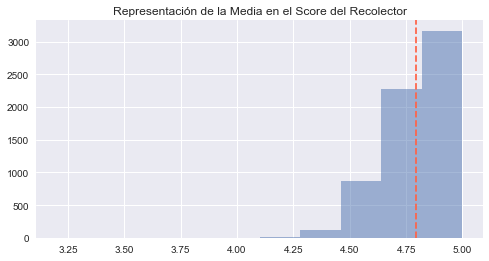

In [97]:
plt.figure(figsize=(8, 4))
plt.hist(df2['score_recolector'], alpha=0.5)
plt.axvline(df2['score_recolector'].mean(), color='tomato', ls='--', label="Media")
plt.title("Representación de la Media en el Score del Recolector");

In [98]:
#Se reemplazan los valores perdidos del atributo por la media del mismo
df['score_recolector'].replace(np.nan, df2['score_recolector'].mean(), inplace=True)

Por otra, una vez imputados los 3 atributos antes mencionados, nos quedó en nuestro consolidado 3 varibales, para este caso si vamos a proceder a eliminar estos datos peridos, ya que son variables que si influyen en el tiempo (vector objetivo) y no queremos que se ve afectado, además, el borrado de estos datos sólo implica el __0.23%__ de la data total.

In [99]:
total = df.isnull().sum().sort_values(ascending=False)
percent = round((df.isnull().sum() / df.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje (%)'])
missing_values

,Total,Porcentaje (%)
pesados,15,0.23
sin_pesar,15,0.23
cantidad_total,15,0.23
latitud,0,0.00
longitud,0,0.00
dia,0,0.00
promesa,0,0.00
entrega,0,0.00
id_entrega,0,0.00
id_recolector,0,0.00


In [100]:
df.dropna(inplace=True)
df.isnull().any()

id_orden                  False
latitud                   False
longitud                  False
dia                       False
promesa                   False
entrega                   False
id_entrega                False
id_recolector             False
id_trasporte              False
id_tienda                 False
tiempo                    False
sin_pesar                 False
pesados                   False
cantidad_total            False
p_aciertos                False
velocidad                 False
p_aceptacion              False
score_recolector          False
seniority_ADVANCED        False
seniority_BEGINNER        False
seniority_INTERMEDIATE    False
seniority_REVIEW          False
tienda                    False
latitud_tienda            False
longitud_tienda           False
dtype: bool

## A2 - Análisis descriptivo

En esta sección se realizará el análisis bivariado entre nuestras variables de interés (seleccionadas en la hipótesis) y la variable objetivo "tiempo" del dataset de 'orden_compras'. Este análisis contendrá gráficos y su respectivas conclusiones.

### A2.1 - Análisis de distancia v/s tiempo de entrega

En este ocasión nuestro dataset consolidado está constituido por __latitudes y longitudes__ tanto de los pedidos como de las tiendas, acá vamos a trabajar con la distancia que se genera entre ellos, aplicando una transformación con la librería `haversine`, el resultado nos dará automáticamente en __Kilometros__ ya que viene por defecto en dicha librería.

In [101]:
#Se crea un dataframe temporal para calcular la distancia
distancias = pd.DataFrame()

distancias['latitud_x'] = pd.to_numeric(df['latitud'].str.replace('.',''))*100/(10**(df['latitud'].str.replace('.','').apply(len)))
distancias['longitud_x'] = (pd.to_numeric(df['longitud'].str.replace('.',''))/(10**(df['longitud'].str.replace('.','').apply(len)))) * 1000

distancias['latitud_y'] = pd.to_numeric(df['latitud_tienda'].str.replace('.',''))*100/(10**(df['latitud_tienda'].str.replace('.','').apply(len)))
distancias['longitud_y'] = (pd.to_numeric(df['longitud_tienda'].str.replace('.',''))/(10**(df['longitud_tienda'].str.replace('.','').apply(len)))) * 1000

In [102]:
df['distancia']= distancias.apply(lambda x: haversine((x['latitud_x'], x['longitud_x']),(x['latitud_y'], x['longitud_y'])), axis=1)

In [103]:
df.tail()

,id_orden,latitud,longitud,dia,promesa,entrega,id_entrega,id_recolector,id_trasporte,id_tienda,tiempo,sin_pesar,pesados,cantidad_total,p_aciertos,velocidad,p_aceptacion,score_recolector,seniority_ADVANCED,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,tienda,latitud_tienda,longitud_tienda,distancia
6538,bb3862027ba277937b009155865d9c5c,1.829.039.721.454.750,-10.034.526.449.340.600,2,10:00:00,9:08:27,1,3932fb19ca90aa0cca6946011732f170,3932fb19ca90aa0cca6946011732f170,6cd78596c7bf5ef34f3d5c197ef2ee8e,70.037.283,9.0,0.0,9.0,0.8480,1.39,0.92,4.84,1,0,0,0,044d56734d20e04984d846dade6d39f3,18.295.042.206.330.300,-1.003.514.953.431.220,0.520673
6539,d2f2a9bd2a4c0768aafaf3d169dca8ee,1.823.137.792.561.540,-10.039.499.206.972.900,2,15:00:00,13:49:02,1,fcdf89d67adaeec14947fed659d1e2c8,fcdf89d67adaeec14947fed659d1e2c8,3dd9ae393aa5327edfb27388758436bd,56.610.628,2.0,0.0,2.0,0.8606,1.57,1.00,4.64,1,0,0,0,0fae7b61265bc7ca4ce4d81440b62501,1.826.223.164.590.900,-1.004.150.072.862.420,3.437287
6540,e813a2be0ff5f6f43e50eb4d876c49ac,18.224.217.974.391.700,-10.041.029.798.727.700,2,12:00:00,10:23:36,1,02297f2f55633ffc8bdec4b28da202fb,02297f2f55633ffc8bdec4b28da202fb,2d69acabaafd2516eeffd3c69b3c1328,132.811.864,47.0,18.0,65.0,0.8674,1.63,0.88,4.44,1,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,18.218.347.218.797.100,-10.041.579.255.293.500,0.655374
6541,521a26393f81cf403f7fcc5093e73665,18.280.581.670.174.800,-10.034.578.943.596.200,2,13:00:00,12:11:55,1,c7fbbbb84c7edb8d10c0238d790d3416,c7fbbbb84c7edb8d10c0238d790d3416,4f01884af565f4d2df35419e09cf58d0,91.013.827,11.0,0.0,11.0,0.8459,1.45,0.96,4.80,1,0,0,0,0fae7b61265bc7ca4ce4d81440b62501,18.300.290.799.329.400,-10.034.753.283.029.000,2.191635
6542,13c6390a1cc8fbab23db8c2d38a56bd1,18.286.601.167.558.300,-10.033.213.517.352.300,2,11:00:00,10:38:28,1,d508e581ef137d531e243586655bcce8,d508e581ef137d531e243586655bcce8,4f01884af565f4d2df35419e09cf58d0,79.770.632,6.0,0.0,6.0,0.8411,1.81,1.00,4.84,1,0,0,0,0fae7b61265bc7ca4ce4d81440b62501,18.300.290.799.329.400,-10.034.753.283.029.000,1.530875


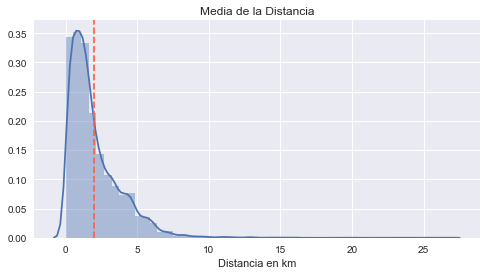

In [104]:
plt.figure(figsize=(8, 4))
sns.distplot(df['distancia'], axlabel='Distancia en km')
plt.axvline(df['distancia'].mean(), color = 'tomato', ls='--', label="Media")
plt.title("Media de la Distancia");

La distancia en kms se encuentrean principalmente entre 0 y 5 kms, incluyendo datos que podemos considerar outliers (como 25 kms de distancia)

In [106]:
df['tiempo'] = pd.to_numeric(df.tiempo.str.replace('.',''))/1000000

Distancia en km vs tiempo en minutos


Text(29.125, 0.5, 'Tiempo')

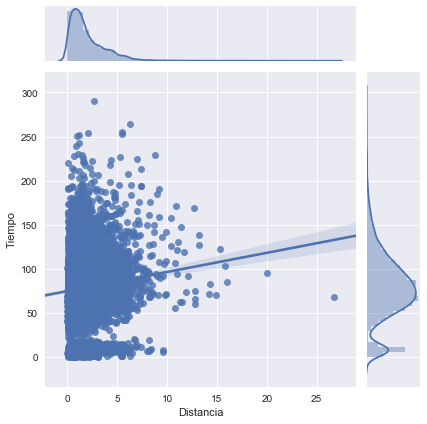

In [109]:
print("Distancia en km vs tiempo en minutos")
sns.jointplot(y='tiempo', x='distancia', data=df, kind="reg")
plt.xlabel("Distancia")
plt.ylabel("Tiempo")

Hay una correlación positiva entre distancia y tiempo, sin embargo es baja y se puede deber a que no puede ser que hay otros atributos que afectan de forma más directa al tiempo, como el día y hora de la semana.

Por ejemplo, si aislamos el día domingo, a las 22 hrs, vemos una correlación positiva entre ambas variables, pero en otros casos esta variable parece no influir, como por ejemplo dia 1 y hora 22.

In [111]:
time = pd.DataFrame(df.entrega.str.split(':', expand=True))
time.columns = ('hora','minuto','segundos')

df['hora'] = pd.to_numeric(time['hora'])

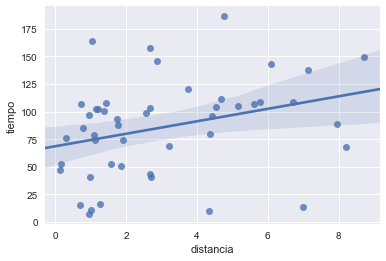

In [113]:
sns.regplot(data=df.query("dia==0 and hora==22"), x='distancia', y='tiempo');

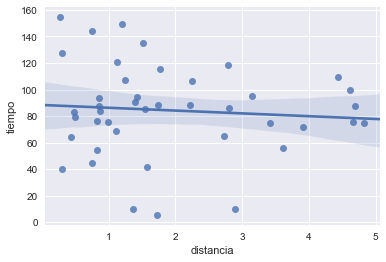

In [114]:
sns.regplot(data=df.query("dia==1 and hora==22"), x='distancia', y='tiempo');

### A2.2 - Análisis de cantidad de productos por orden v/s tiempo de entrega

### A2.2.1 - Distribución de productos por orden

In [115]:
df['pesaje'] = np.where(df['pesados'] >= 1, 1, 0)

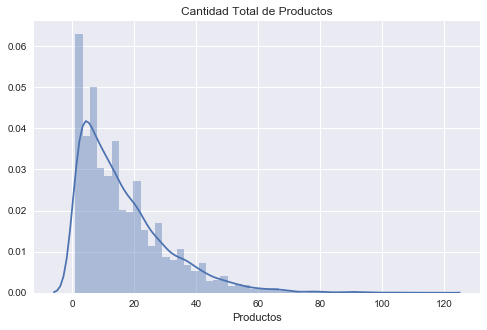

In [116]:
plt.figure(figsize=(8, 5))
sns.distplot(df['cantidad_total'])
plt.xlabel("Productos")
plt.title("Cantidad Total de Productos");

La mayor cantidad de compras son de cantidades bajas de productos, con un promedio de 16.7 productos por pedido

In [117]:
print("Promedio de Productos por compra:", round(df['cantidad_total'].mean(), 2))

Promedio de Productos por compra: 16.67


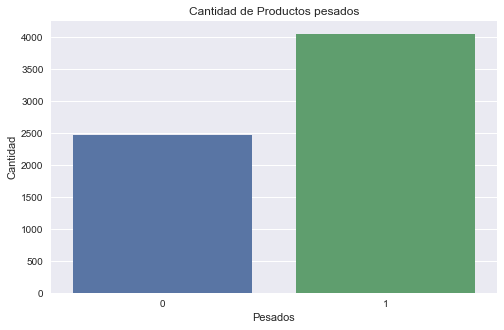

In [92]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='pesaje')
plt.xlabel("Pesados")
plt.ylabel("Cantidad")
plt.title("Cantidad de Productos pesados");

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x360 with 0 Axes>

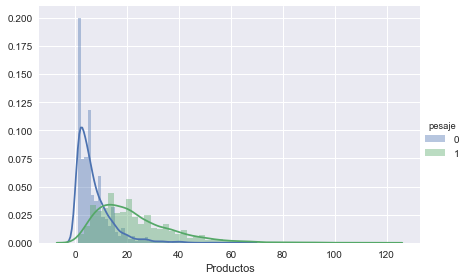

In [93]:
plt.figure(figsize=(10, 5))
g = sns.FacetGrid(df, hue="pesaje", size=4, aspect=1.5)
g = g.map(sns.distplot, "cantidad_total")
g.add_legend()
plt.xlabel("Productos");

In [94]:
print("Promedio de productos en ordenes sin productos que deban ser pesados = ", round(df.query("pesaje==0")['cantidad_total'].mean(), 2))
print("Promedio de productos en ordenes con productos que deban ser pesados = ", round(df.query("pesaje==1")['cantidad_total'].mean(), 2))

Promedio de productos en ordenes sin productos que deban ser pesados =  7.04
Promedio de productos en ordenes con productos que deban ser pesados =  22.54


El gráfico ademas nos muestra que aquellas compras que tienen productos que se deben pesar, tienen una distribución diferente a aquellos en los que no se pide ningun producto de pesaje, siendo su promedio mayor en aquellos que deben ser pesados

### A2.2.2 - Relación con el tiempo de entrega

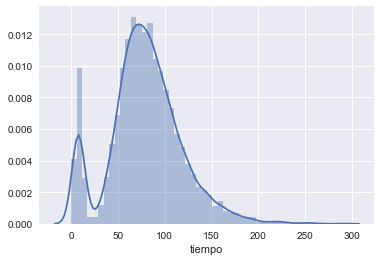

In [98]:
sns.distplot(df.tiempo);

Es necesario revisar ese peak en los valores más bajos, ya que se puede deber a una mala codificación

El gráfico muestra evidencia para apoyar nuestra hipótesis, ya que se ve una correlación positiva entre la cantidad total de productos con el tiempo de entrega.

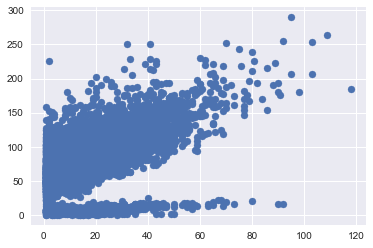

In [99]:
import seaborn as sns
plt.scatter(data=df, x='cantidad_total', y='tiempo')

### A2.3 - Calificación del repartidor v/s tiempo de entrega

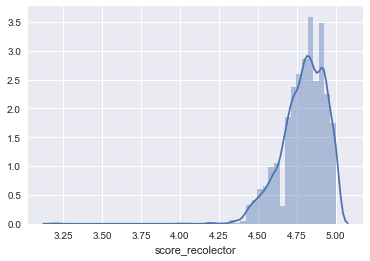

In [100]:
sns.distplot(df.score_recolector);

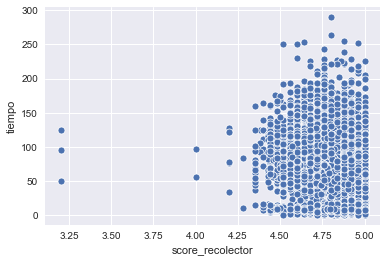

In [101]:
sns.scatterplot(data=df, x='score_recolector', y='tiempo');

En el caso del "Rating" del repartidor, de momento el gráfico no nos permite saber si es influyente en el tiempo de entrega, sobre todo por el hecho de que la distribución de las calificaciones es muy acotada entre 4.50 y 5

### A2.4 - Hora/Día de la semana v/s tiempo de entrega

### A2.4.1 - Hora

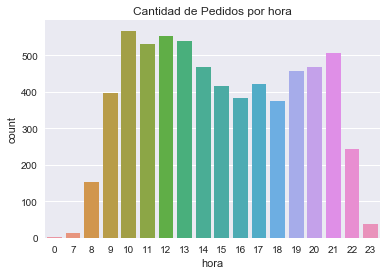

In [82]:
sns.countplot(data=df, x='hora',).set_title('Cantidad de Pedidos por hora');

La Mayor cantidad de pedidos se concentra entre 10 y 13, cayendo hasta retomar desde las 19 a las 21 hrs

In [102]:
df.groupby('hora').mean()['tiempo']

hora
0      41.912408
7      45.002192
8      68.670544
9      83.626490
10     77.851561
11     78.973790
12     78.656839
13     80.050899
14     79.716363
15     78.664720
16     76.192815
17     72.904469
18     78.725124
19     81.383109
20     77.227860
21     81.819288
22     87.318738
23    103.909170
Name: tiempo, dtype: float64

Text(0.5, 1.0, 'Hora vs Tiempo de entrega')

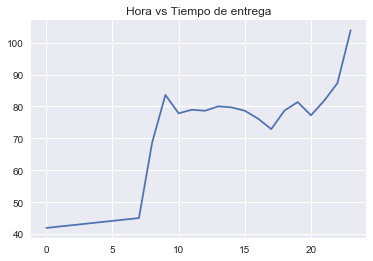

In [103]:
plt.plot(df.groupby('hora').mean()['tiempo'])
plt.title('Hora vs Tiempo de entrega')

Revisando las horas, notamos que a las 9 hay un peak, al igual que a las 19 horas y luego pasado las 21 hrs

### A.2.4.2 - Dia de la semana

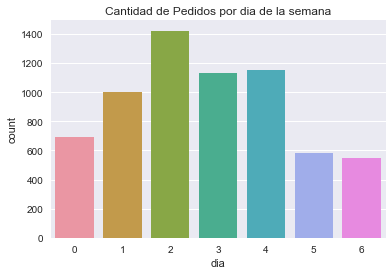

In [105]:
sns.countplot(data=df, x='dia',).set_title('Cantidad de Pedidos por dia de la semana');

De Lunes a jueves se concentra la mayor cantidad de pedidos, siendo viernes a domingo los que tienen menos edidos

In [ ]:
df.groupby('dia').mean()['tiempo']

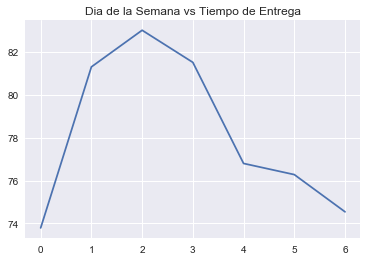

In [106]:
plt.plot(df.groupby('dia').mean()['tiempo'])
plt.title('Dia de la Semana vs Tiempo de Entrega');

El tiempo de entrega es consistente con la cantidad de pedidos de cada día, excepto en el dia jueves, donde es menor en promedio que la cantidad de pedidos del mismo día

### A2.4.3 - Dia y Fecha

In [107]:
table = pd.pivot_table(df, values='tiempo', index=['hora'], columns=['dia'], aggfunc=np.mean)

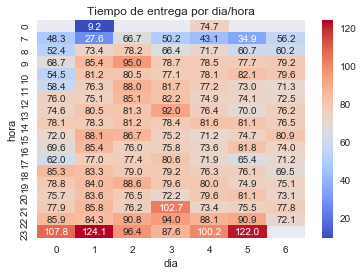

In [108]:
sns.heatmap(table,annot=True, cmap='coolwarm', fmt=".1f").set_title("Tiempo de entrega por dia/hora");

Notamos que diferentes dias tienen diferentes peaks de tiempo de demora, por ejemplo, los dias lunes hay grandes tiempos de entrega entre 15 y 16, y luego entre 18 y 22. Por otro lado, el dia martes tiene altos tiempos de entrega duante la mañana. El dia miercoles a las 21 hrs tiene untiempode espera superlativamente mayor al resto de los dias.
